In [1]:
# allow for imports from ../src directory

from os import path as os_path
from os import getcwd
from sys import path as sys_path

sys_path.append(os_path.dirname(getcwd())) 

In [2]:
import scipy.optimize as optim
import numpy as np
import pandas as pd
import siunits as unit

from scipy.integrate import trapezoid
from scipy.constants import epsilon_0, elementary_charge, Boltzmann, Avogadro
from src.helper_functions import read_render_markdown_file, make_simple_plot

### Physical constants

1. the electric constant (vacuum permittivity) $\epsilon_0$. Units:  $\textstyle{\rm s^{4}\cdot A^{2}\cdot kg^{-1}\cdot m^{-3}}$ or $\textstyle{\rm C^2 \cdot N^{−1} \cdot m^{−2}}$ or $\textstyle{\rm C \cdot V^{−1} \cdot m^{−1}}$ 

In [3]:
unit.epsilon_0

ampere²·second⁴·meter⁻³·kilogram⁻¹ (A²·s⁴·m⁻³·kg⁻¹), [kg: -1, s: 4, A: 2, m: -3]

In [4]:
epsilon_0

8.8541878128e-12

2. Elementary charge (charge on electron). Units: $\rm C$

In [5]:
unit.c

coulomb (C), [s: 1, A: 1]

In [6]:
elementary_charge

1.602176634e-19

3. Boltzmann constant. Units: $\rm m^2 \cdot kg \cdot s^{-2} \cdot {K}^{-1}$

In [7]:
Boltzmann

1.380649e-23

4. Avogadro's number. Units: $\rm mol^{-1}$

In [8]:
Avogadro

6.02214076e+23

### Singlet model parameters

See Page 62

In [9]:

# component = ["K", "Cl"]            # KCl (potassium chloride)
# valence = np.array([1.0, -1.0])    # 1-1 electrolyte

In [10]:
# temperature = 1075.0               # 1075 K
# concentration = 19.265             # mol dm^{-3}

In [11]:
psi_0 = 0     # 0 mV  -- get from UI

Dictionary of parameters

In [12]:
fluid = "kcl"

In [13]:
parameters = dict({"kcl": dict({"component": ["K", "Cl"], "valence": np.array([
                  1.0, -1.0]), "temperature": 1075.0, "concentration": [19.265, 19.265]})})


In [14]:
for param_name in parameters[fluid].keys():
    locals().__setitem__(param_name, parameters[fluid][param_name])
    print(f"Created variable - {param_name}: {str(parameters[fluid][param_name])}")


n_component = len(component)

Created variable - component: ['K', 'Cl']
Created variable - valence: [ 1. -1.]
Created variable - temperature: 1075.0
Created variable - concentration: [19.265, 19.265]


rho ($\rho$) is the number density which we calculate from the concentration ($c$):

$\rho = c \, \rm mol \, dm^{-3} \cdot dm^{3} / 1.0 \cdot 10^{27} \cdot A^{3} \cdot N_{A} \, mol^{-1}$. Units: $\rm A^{-3}$


In [15]:
def calc_rho(concentration):
    return np.array(concentration) / 1.0e27 * Avogadro

In [16]:
rho = calc_rho(concentration)

In [17]:
rho   # values seem reasonable (compared with those in thesis)

array([0.01160165, 0.01160165])

In [18]:
def calc_charge(valence):
    return valence * elementary_charge

In [19]:
charge = calc_charge(valence)

In [20]:
epsilon = 4.0 * np.pi * epsilon_0   # units same as $\epsilon_0$

$\beta = 1 / k T$. Units: $\rm m^{-2} \cdot kg^{-1} \cdot s^{2}$

In [21]:
beta = 1.0 / (Boltzmann * temperature)

In [22]:
beta

6.737646991665042e+19

In [23]:
def calc_kappa(beta, rho, epsilon):
    return np.sqrt(4.0 * np.pi * beta / epsilon * 1e10 *
    sum(np.multiply(charge**2, rho)))


In [24]:
kappa = calc_kappa(beta, rho, epsilon)

In [25]:
kappa      # similar to thesis value (6.77) page 62 - maybe revisions to physical constants in past 25 years (e.g. 2019 change for $e$)

6.732325586635704

### Discretisation of functions

In [26]:
z_cutoff = 50.0    # from UI
n_point = 2001     # from UI
grid_size = z_cutoff / (n_point - 1) 
z = np.linspace(0.0, z_cutoff, n_point)

### Wall-ion soft-potential

In [27]:
phiw = np.zeros((n_point, n_component))
hw = np.zeros((n_point, n_component))
tw = np.zeros((n_point, n_component))
int_0_z = np.zeros((n_point, n_component))
int_z_inf = np.zeros((n_point, n_component))

In [28]:
# same for both ions

def calc_phiw(z, n_component):
    capital_a = 16.274e-19 # joules
    wall_d = 2.97  # inverse Angstrom
    for i in range(n_component):
        phiw[:, i] = np.exp(-wall_d * z) * capital_a * (wall_d * z + 2)
    return phiw


In [29]:
beta_phiw = beta * calc_phiw(z, n_component)

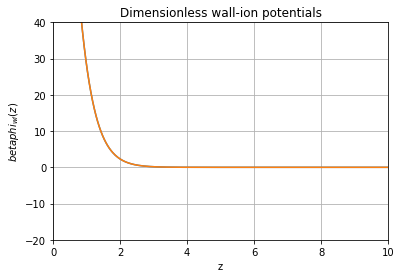

'Dimensionless wall-ion potentials'

In [30]:
make_simple_plot(z, beta_phiw, "z", "$beta phi_{wi}(z)$", "Dimensionless wall-ion potentials")

This dimensionless plot matches well with Figure 4.1(b) of thesis.

### Bulk fluid inputs

Not sure what to do here -- maybe run pyOZ for ionic fluid and try using c_{ij}(r) from this as an approximation?

In [31]:
read_render_markdown_file("../docs/equation_3_4.md")

$$ f_{ij}^{(n)}(z) = \int_z^{\infty} dr r^n c_{ij}^{*} $$

In [32]:
def calc_l_index(i, j):
    return i + j       

In [33]:
l = 0
for i in range(n_component):
    for j in range(i, n_component):
        l = l+1
        print(f"i: {i}, j: {j}, l: {l}", calc_l_index(i, j))

i: 0, j: 0, l: 1 0
i: 0, j: 1, l: 2 1
i: 1, j: 1, l: 3 2


In [34]:
# Assume all of the moments of the short-ranged bulk direct correlation functions to be zero initially

n_pair = int((n_component+1) * (n_component) / 2)

f1 = np.zeros((n_point, n_pair))
f2 = np.zeros((n_point, n_pair))
c_short = np.zeros((n_point, n_pair))

In [35]:
#TODO: Fix up choice of c(r) / c*(r) and make sure discretisation matches

# Read in some c(r)
def load_cr():
    CR_PATH = "../pyOZ_bulk_fluid/tests/lj/nrcg-cr.dat.orig"
    cr = pd.read_csv(CR_PATH, header=None, delim_whitespace=True)
    cr.set_index(0, inplace=True)
    return cr



<AxesSubplot:xlabel='0'>

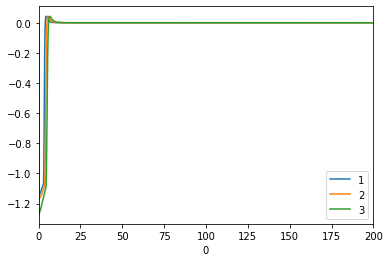

In [36]:
cr_in = load_cr()
cr_in.plot(xlim=[0, 200])

In [37]:
# for now assume c*(r) = c(r)

c_short = cr_in.to_numpy(dtype=np.float64)

In [38]:
r = cr_in.index.to_numpy()

In [39]:
charge_pair = np.array([1, -1, 1]) * elementary_charge

In [40]:
read_render_markdown_file("../docs/equation_3_5.md")

$$ c_{ij}^*(r) = c_{ij}(r) + \beta q_i q_j / (\varepsilon r) $$

In [41]:
# numpy resources - understanding 1D arrays

# See https://stackoverflow.com/questions/5954603/transposing-a-1d-numpy-array

# https://stackoverflow.com/questions/65248933/best-approach-to-use-numpy-1d-arrays-for-linear-algebra

# https://www.oreilly.com/library/view/python-for-data/9781449323592/ch04.html

# https://phys.libretexts.org/Bookshelves/Mathematical_Physics_and_Pedagogy/Computational_Physics_(Chong)/04%3A_Numerical_Linear_Algebra/4.01%3A_Array_Representations_of_Vectors_Matrices_and_Tensors

In [76]:
#TODO: Too big?

beta * charge_pair[0] / epsilon / 1e10

9.701972803875785

In [43]:
c_short

array([[ 0.     ,  0.     ,  0.     ],
       [-1.14632, -1.16466, -1.26896],
       [-1.14616, -1.16463, -1.26875],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]])

In [44]:
# skip r = 0 to avoid divide by 0 error

#for l in range(n_pair):
#    c_short[1:, l] = c_short[1:, l]  + beta * charge_pair[l] * 1e-10 / (epsilon * r[1:])
    

In [45]:
c_short

array([[ 0.     ,  0.     ,  0.     ],
       [-1.14632, -1.16466, -1.26896],
       [-1.14616, -1.16463, -1.26875],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]])

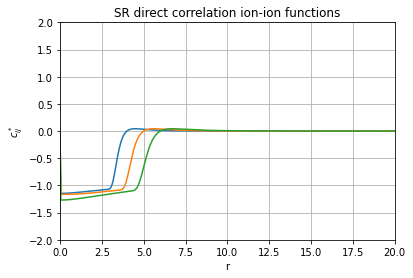

'SR direct correlation ion-ion functions'

In [75]:
make_simple_plot(r, c_short, "r", "$c_{ij}^*$", "SR direct correlation ion-ion functions", xliml=[0, 20], yliml=[-2, 2])

In [47]:
def int_z_infty_dr_r_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f1[k, ij] = trapezoid(y=z[:k] * c_short[k, ij], x=z[:k])
    return f1

In [48]:
def int_z_infty_dr_r2_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f2[k, ij] = trapezoid(y=z[:k] * z[:k] * c_short[k, ij], x=z[:k])
    return f2

In [49]:
f1 = int_z_infty_dr_r_c_short(c_short, z)

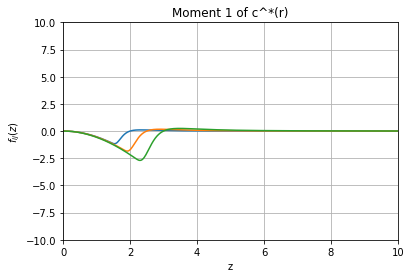

'Moment 1 of c^*(r)'

In [73]:
make_simple_plot(z, f1, "z", "$f_{ij}(z)$", "Moment 1 of c^*(r)", yliml=[-10, 10])

In [51]:
f2 = int_z_infty_dr_r2_c_short(c_short, z)

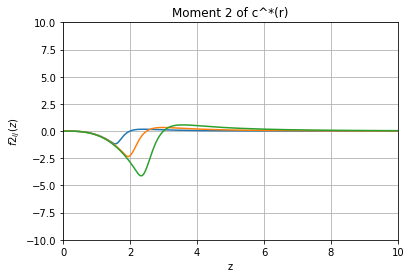

'Moment 2 of c^*(r)'

In [72]:
make_simple_plot(z, f2, "z", "$f2_{ij}(z)$", "Moment 2 of c^*(r)", yliml=[-10, 10])

Initial guess for solution $t_{wi}(z)$ - solving $F(t(z)) = 0$

In [53]:
tw = np.zeros((n_point, n_component))    # initial guess of zero - maybe should be \beta \phi

# tw = beta_phiw_i

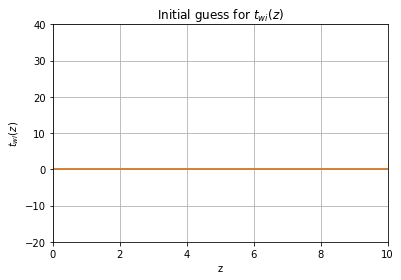

'Initial guess for $t_{wi}(z)$'

In [54]:
make_simple_plot(z, tw, "z", "$t_{wi}(z)$", "Initial guess for $t_{wi}(z)$")

In [55]:
def calc_hw(tw, beta_phiw):
    for i in range(n_component):
        hw[:, i] = np.exp(tw[:, i]) * np.exp(-beta_phiw[:, i]) - 1.0
        return hw


In [56]:
hw = calc_hw(tw, beta_phiw)

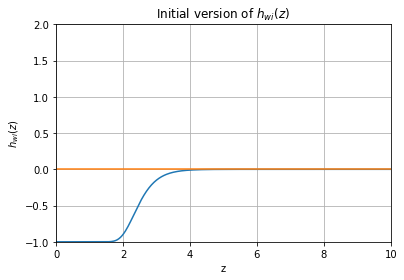

'Initial version of $h_{wi}(z)$'

In [57]:
make_simple_plot(z, hw, "z", "$h_{wi}(z)$", "Initial version of $h_{wi}(z)$", yliml=[-1, 2])

In [58]:
beta_psi =  psi_0 * charge * beta

In [59]:
read_render_markdown_file("../docs/equation_5_9.md")
read_render_markdown_file("../docs/equation_5_9b.md")

$$ \large t_{wi}(z) = \ln \left[ g_{wi}(z) \exp(\beta \phi_{wi}(z)) \right] $$

$$ t_{wi}(z) ~=~ - \beta q_i \psi_0 + 2 \pi \sum_{j} \bar{\rho_j} \left \{  z f_{ij}^{(1)}(z) - f_{ij}^{(2)}(z) - \left( 2 \beta q_i q_j / \varepsilon \right ) \left(  \int_0^z dt t h_{wj}(t) + z \int_{z}^{\infty} dt h_{wj}(t) \right) + \int_0^{\infty} dt h_{wj}(t) f_{ij}^{(1)} ( | z - t | ) \right \} $$

In [60]:
def calc_tw(tw, beta_psi, beta_phiw, rho, f1, f2, z):
    hw = calc_hw(tw, beta_phiw)

    for i in range(n_component):
        tw[:, i] = -beta_psi[i] 
        for k, _ in enumerate(z):
            int_0_z[k, i] = trapezoid(y=z[:k] * hw[:k, i], x=z[:k])
            int_z_inf[k, i] = trapezoid(y=hw[k:, i], x=z[k:])
            for j in range(n_component):
                l = calc_l_index(i, j)
                tw[k, i] = tw[k, i] + 2.0 * np.pi * rho[j] * (z[k] * f1[k, l] - f2[k, l])
                
            #TODO: NEXT: Complete adding f_ij(z) terms - need to fix sum_{ij} for f functions

            #     2.0 * np.pi * (rho[i] * z[k] * f1[k, i] - f2[k, i]) + \
            #    2.0 * charge[i] * charge[j] / epsilon * (int_z_inf[k, i] + z[k] * int_0_z[k, i])  # + int_0_inf
    return tw


In [61]:
calc_tw(tw, beta_psi, beta_phiw, rho, f1, f2, z)

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-1.31598304e-06, -1.38579742e-06],
       ...,
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])

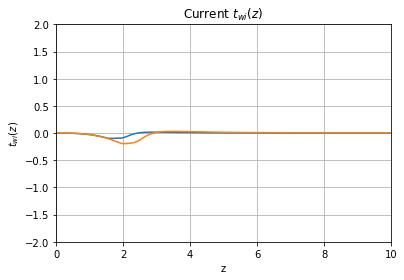

'Current $t_{wi}(z)$'

In [71]:
make_simple_plot(z, tw, "z", "$t_{wi}(z)$", "Current $t_{wi}(z)$", yliml=[-2, 2])

### Numerical solver: Newton-GMRES

In [63]:
# this should equal 0 (as t(z) converges to solution)

def func_opt(tw):
    return tw - calc_tw(tw, beta_psi, beta_phiw, rho, f1, f2, z)

In [64]:
tolerance = 1e-9

In [65]:
solution = optim.root(func_opt, tw, method="krylov", jac=None, tol=tolerance, callback=None, options=None)

In [66]:
tw_solution = solution.x

In [67]:
tw_solution

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-1.31598304e-06, -1.38579742e-06],
       ...,
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])

In [68]:
hw_solution = calc_hw(tw_solution, beta_phiw)

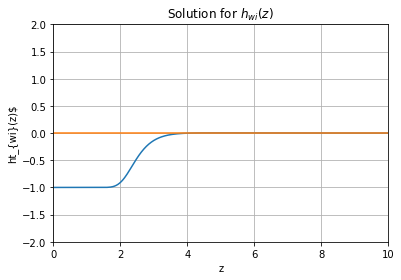

'Solution for $h_{wi}(z)$'

In [70]:
make_simple_plot(z, hw_solution, "z", "ht_{wi}(z)$", "Solution for $h_{wi}(z)$", yliml=[-2, 2])